In [1]:
import numpy as np
import matplotlib.pyplot as plt


import operator as op
import functools as ft

def summ(a_map):
    "sum(map) does not do what one would expect it to do, but summ(map) does"
    return ft.reduce(op.add, a_map)

def integr(acc, new):
    "reduction function to compute an integral"
    if not acc: 
        acc = [0]
        last = 0
    else:
        last = acc[-1]
        
    acc.append(last+new)
    return acc
  
def pf(Proba):
    "converting uniform draw into binary draw (factory function)"
    def f(x):
        return 0 if x>P else 1
    f.__doc__ = "converts uniform draw into binary draw with proba %.4f" % Proba
    return f

from scipy.misc import comb
def pdf(n,p,k):
    "the binomial density function B(n,p,k)"
    return comb(n, k) * p**k * (1-p)**(n-k)

In [2]:
def gaussf(mu=0.0,sig=1.0):
    "factory function, returning an unnormalised Gaussian"
    def _gaussf(x):
        z = (x - mu)/sig
        return exp(-z*z)
    
    _gaussf.__doc__ = "unnormalised Gaussian (mu=%f, sig=%f)" % (mu,sig)
    return _gaussf

def constf(c=1.0):
    "factory function, returning an constant function"
    def _constf(x):
        return c + 0 * x

    _constf.__doc__ = "constant function (c=%f)" % (c)
    return _constf

def normalised(y, x):
    "returns normalised y-vector (unity integral, over x; x assumed to be equally spaced)"
    dx = x[1] - x[0]
    s = sum(y) * dx
    return y / s

#f = constf()
#g = gaussf()
#help(g)

In [3]:
class bayes2:
    """simple class allowing to compute Bayesian combination of two measurements
    
    DESCRIPTION
        
        the following properties are used to construct the data

            min, max, n - support area (and grid steps)
            mu1, sig1 - first measurement
            mu2, sig2 - second measurement

            title, xlabel, ylabel - graph labels
       
       the function draw() then draws it
        
    DEPENDENCIES
        
        normalised()
        gaussf()
        constf()
    """

    
    def __init__(self):
        self.n = 1000
        
        self.mu1 = 5
        self.sig1 = 1
        self.mu2 = 6
        self.sig2 = 2
        
        self.min = 0.
        self.max = 10.
        
        self.title = 'Measurements and Bayesian post density function'
        self.xlabel = 'probability space location'
        self.ylabel = 'probability density'
        
    def draw(self):
        x = np.linspace(self.min, self.max, 1000)
        prior = constf(0.5)(x)
        f1 = normalised(gaussf(self.mu1,self.sig1)(x),x)
        f2 = normalised(gaussf(self.mu2,self.sig2)(x),x)
        ff = normalised(f1 * f2,x)
        #plt.plot(x,prior, label='prior')
        plt.plot(x,f1, 'k--', label='m1')
        plt.plot(x,f2,  'k--', label='m2')
        plt.plot(x,ff, 'r-', label='post')
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.legend()
        plt.show()

b = bayes2()

In [50]:
def gaussf(mu=0.0,sig=1.0):
    """factory function, returning an unnormalised Gaussian
    """
    def _gaussf(x):
        z = (x - mu)/sig
        return exp(-z*z)

    _gaussf.__doc__ = "unnormalised Gaussian (mu=%f, sig=%f)" % (mu,sig)
    return _gaussf

def stepf (min=None, max=None):
    """factory function, returning a step function

    the returned function yields 1 between min and max (inclusive), 0 else
    None means -infty / +infty respectively
    """
    if min == None: min = float("-inf")
    if max == None: max = float("inf")
        
    def _stepf(x):
        if x > max or x < min: return 0.
        else: return 1.

    _stepf.__doc__ = "step function (min=%f, max=%f)" % (min,max)
    return _stepf


class bayes:
    
    def __init__(self, min=0., max=1., steps=100):
        self.min = min
        self.max = max
        self.steps = steps
        self.dx = (max-min)/steps
        self.x = np.linspace(self.min, self.max, self.steps)
        
        self.title = 'Measurements and Bayesian post density function'
        self.xlabel = 'probability space location'
        self.ylabel = 'probability density'

        self._funcs = []
        self.labels = []
        return
    
    def normalise(self, f):
        """normalise a function vector to unit mass"""
        
        integral = sum(f) * self.dx
        return f/integral
        
    
    def addf (self, f, label=None, normalise=True):
        y = list(map(f, self.x))
        y = self.normalise(y)
        self._funcs.append(y)
        self.labels.append(label)
        
    def plot(self):
        
        for i, y in enumerate(self._funcs):
            plt.plot(self.x, y, label=self.labels[i])
        
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.legend()
        plt.show()

            
b = bayes()            
    

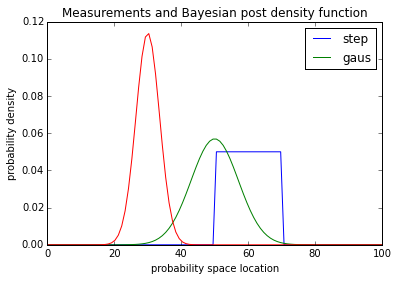

In [55]:
b = bayes(0., 100., 100)
b.addf(stepf(50, 70), "step")
b.addf(gaussf(50,10), "gaus")
b.addf(gaussf(30,5))
b.plot()

#Frequentist vs Bayesian statistics - Part II

We know that in a Bayesian setting the probability of our hypothesis conditional on our data is
$$
P(H|D) \propto P(D|H) \times P(H)
$$
where $P(H)$ is the prior, and $P(D|H)$ is the probability of our data conditional on the hypothesis. 

What we are looking at now is a situation where we have two measurements for the same quantity, say two people measuring a length. One of the measurements is $\mu_1, \sigma_1$ (in the sense that the measurement we've got is $\mu_1$, and the measurement carries a Gaussian error of standard deviation $\sigma_1$), and the other one is $\mu_2, \sigma_2$.

In principle we are starting with a flat prior $P(H)$*, that we are then updating with the first measurement to obtain our new prior $P_1(H) = P(H|D1)$, that in turn we are updating with the second measurement. 
$$
P(H|D_1, D_2) \propto P(D_2|H) \times P_1(H) \propto P(D_2|H) \times P(D_1|H) \times P(H)
$$
However, because the first prior is flat we can simply use $P(D_1|H)$ as our first and only prior.

*note: in fact we are starting not with a flat prior, but with a prior that has support $[min\ldots max]$ by virtue of the fact that we are not evaluating the functions outside of this area; this is one of the rather nice properties of this calculus: restricting the calculation area to an interval is a feature